In [26]:
# We create a file where all images will be stored

data_dir = './64'
import helpers
import math
import os
import sys
import hashlib
from urllib.request import urlretrieve
import zipfile
import gzip
import shutil
import glob

import numpy as np
from PIL import Image
from tqdm import tqdm


In [27]:
print(os.getcwd())

/home/ubuntu/poster_generator


In [28]:
from PIL import Image
import os
import glob

# NOTE
# Helper Cell Create Thumbnail fith images




# TODO: Get images from ./data recursively.
# data_dir = '.'
# size = (64, 64)

# for f in os.listdir('.'):
#     if f.endswith('.jpg'):
#         i = Image.open(f)
#         rgb_im = i.convert('RGB')
#         rgb_im.save(f)
#         i = Image.open(f)
#         i.thumbnail(size, Image.ANTIALIAS)
#         fn, fext = os.path.splitext(f)
#         i.save('64/{}64{}'.format(fn, fext))

# Use command line to mv ./240/* ./
# Apply this snippet and aft



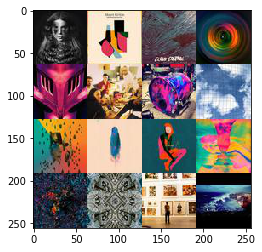

In [29]:
show_n_images = 20


%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np
import math

poster_images = helpers.get_batch(glob(os.path.join(data_dir, '*.jpg'))[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helpers.images_square_grid(poster_images, 'RGB'))

## Check GPU Version

In [30]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [31]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim = (image_width ,image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate

### Discriminator

In [48]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64x64x3
#         print("number of images in discriminator",images)
        x = tf.layers.conv2d(images, 64, 5, strides=(2, 2), padding='same')
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # Now 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 4x4x256
        
        # Flatten to 1D tensor
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        # Now 4x4x256
        logits = tf.layers.dense(x, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits



### Generator

In [63]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 4 * 4 * 1024)
        # Reshape tensor with -1 to flaten into a 1d
        x = tf.reshape(x, (-1, 4, 4, 256))
        # Batch Norm
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # now 4x4x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=(4, 4), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 16x16x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 32x32x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        print("image shape in discriminator",x.shape)
        # now 64x64x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=(1, 1), padding='same')
        output = tf.tanh(logits)
        # now 64x64x3
        
        return output



### Loss

In [64]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

### Optimization

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt




## Neural Network Training

### Show Output

In [66]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helpers.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train

In [107]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build Model    
    # Reset number of steps
    samples, losses = [], []
    steps = 0
    
    # Print training data
    print_every = 10
    show_every = 100
    
    # Pass dim 3 or 1 depending if images have color or not
    if (data_image_mode == 'RGB'):
        out_channel_dim=3
    else:
        out_channel_dim=1
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # Restore variables from disk.
        saver.restore(sess, "./tmp/model-64.ckpt")
        print("Model restored.")
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # The values of the Posters dataset will be in the range of -0.5 to 0.5 of 240x240 
                # dimensional images fot fit our random uniform we multiply by 1.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
                    # Save the variables to disk.
                    save_path = saver.save(sess, "./tmp/model-64.ckpt")
                    print("Model saved in path: %s" % save_path)

        
        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode)
        return losses, samples
                
                

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

### Poster

image shape in discriminator (?, 64, 64, 64)
INFO:tensorflow:Restoring parameters from ./tmp/model-64.ckpt
Model restored.
Epoch 2/500... Discriminator Loss: 0.1501... Generator Loss: 2.6316
Epoch 3/500... Discriminator Loss: 0.3021... Generator Loss: 2.1493
Epoch 4/500... Discriminator Loss: 0.6795... Generator Loss: 1.2065
Epoch 5/500... Discriminator Loss: 1.4395... Generator Loss: 0.6092
Epoch 7/500... Discriminator Loss: 1.0202... Generator Loss: 2.1807
Epoch 8/500... Discriminator Loss: 0.8342... Generator Loss: 1.2838
Epoch 9/500... Discriminator Loss: 0.7065... Generator Loss: 1.1795
Epoch 10/500... Discriminator Loss: 0.5520... Generator Loss: 1.3910
Epoch 12/500... Discriminator Loss: 0.3169... Generator Loss: 2.4095
Epoch 13/500... Discriminator Loss: 0.3534... Generator Loss: 1.9285
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


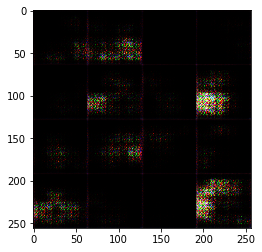

Model saved in path: ./tmp/model-64.ckpt
Epoch 14/500... Discriminator Loss: 0.3697... Generator Loss: 1.7541
Epoch 15/500... Discriminator Loss: 0.2161... Generator Loss: 2.5021
Epoch 17/500... Discriminator Loss: 0.1732... Generator Loss: 3.2960
Epoch 18/500... Discriminator Loss: 1.1145... Generator Loss: 4.0555
Epoch 19/500... Discriminator Loss: 0.8136... Generator Loss: 1.7393
Epoch 20/500... Discriminator Loss: 0.2328... Generator Loss: 2.6519
Epoch 22/500... Discriminator Loss: 0.1389... Generator Loss: 2.7485
Epoch 23/500... Discriminator Loss: 0.4067... Generator Loss: 1.7091
Epoch 24/500... Discriminator Loss: 0.7780... Generator Loss: 1.0068
Epoch 25/500... Discriminator Loss: 0.2773... Generator Loss: 2.2663
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


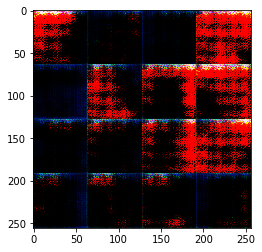

Model saved in path: ./tmp/model-64.ckpt
Epoch 27/500... Discriminator Loss: 0.7397... Generator Loss: 1.1336
Epoch 28/500... Discriminator Loss: 0.4159... Generator Loss: 1.7552
Epoch 29/500... Discriminator Loss: 0.4908... Generator Loss: 1.4254
Epoch 30/500... Discriminator Loss: 0.6356... Generator Loss: 1.4416
Epoch 32/500... Discriminator Loss: 1.2484... Generator Loss: 2.2861
Epoch 33/500... Discriminator Loss: 1.1334... Generator Loss: 1.5288
Epoch 34/500... Discriminator Loss: 1.2390... Generator Loss: 1.3703
Epoch 35/500... Discriminator Loss: 0.9542... Generator Loss: 1.3133
Epoch 37/500... Discriminator Loss: 0.8828... Generator Loss: 1.7426
Epoch 38/500... Discriminator Loss: 0.8501... Generator Loss: 0.9132
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


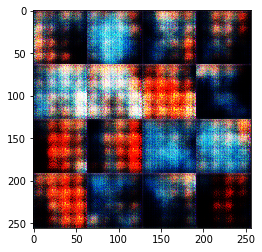

Model saved in path: ./tmp/model-64.ckpt
Epoch 39/500... Discriminator Loss: 1.1641... Generator Loss: 0.5856
Epoch 40/500... Discriminator Loss: 1.0487... Generator Loss: 0.9195
Epoch 42/500... Discriminator Loss: 0.6377... Generator Loss: 1.5043
Epoch 43/500... Discriminator Loss: 0.5822... Generator Loss: 1.3182
Epoch 44/500... Discriminator Loss: 0.6044... Generator Loss: 1.9177
Epoch 45/500... Discriminator Loss: 0.6245... Generator Loss: 1.2191
Epoch 47/500... Discriminator Loss: 0.9429... Generator Loss: 1.5964
Epoch 48/500... Discriminator Loss: 1.3708... Generator Loss: 2.0521
Epoch 49/500... Discriminator Loss: 0.8452... Generator Loss: 1.0513
Epoch 50/500... Discriminator Loss: 0.4600... Generator Loss: 1.8602
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


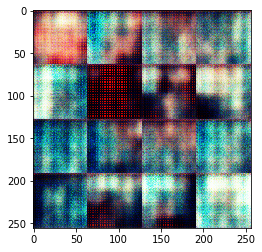

Model saved in path: ./tmp/model-64.ckpt
Epoch 52/500... Discriminator Loss: 0.7355... Generator Loss: 1.2266
Epoch 53/500... Discriminator Loss: 0.5316... Generator Loss: 1.3858
Epoch 54/500... Discriminator Loss: 0.7849... Generator Loss: 2.1456
Epoch 55/500... Discriminator Loss: 1.0094... Generator Loss: 1.0634
Epoch 57/500... Discriminator Loss: 0.7032... Generator Loss: 1.1189
Epoch 58/500... Discriminator Loss: 0.9178... Generator Loss: 1.1012
Epoch 59/500... Discriminator Loss: 1.2254... Generator Loss: 1.7848
Epoch 60/500... Discriminator Loss: 0.9075... Generator Loss: 1.0882
Epoch 62/500... Discriminator Loss: 0.6150... Generator Loss: 1.2978
Epoch 63/500... Discriminator Loss: 0.8125... Generator Loss: 1.0289
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


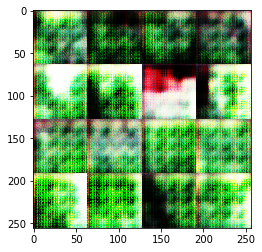

Model saved in path: ./tmp/model-64.ckpt
Epoch 64/500... Discriminator Loss: 0.7198... Generator Loss: 1.1070
Epoch 65/500... Discriminator Loss: 1.4260... Generator Loss: 0.4265
Epoch 67/500... Discriminator Loss: 0.5263... Generator Loss: 1.5828
Epoch 68/500... Discriminator Loss: 0.7139... Generator Loss: 1.1519
Epoch 69/500... Discriminator Loss: 0.5997... Generator Loss: 1.1689
Epoch 70/500... Discriminator Loss: 0.7932... Generator Loss: 1.0149
Epoch 72/500... Discriminator Loss: 0.4583... Generator Loss: 1.6096
Epoch 73/500... Discriminator Loss: 0.5804... Generator Loss: 1.7104
Epoch 74/500... Discriminator Loss: 0.6669... Generator Loss: 1.1755
Epoch 75/500... Discriminator Loss: 0.7315... Generator Loss: 0.9799
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


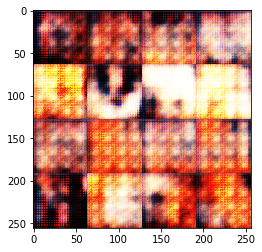

Model saved in path: ./tmp/model-64.ckpt
Epoch 77/500... Discriminator Loss: 0.5837... Generator Loss: 1.1981
Epoch 78/500... Discriminator Loss: 0.4778... Generator Loss: 1.5265
Epoch 79/500... Discriminator Loss: 0.6626... Generator Loss: 1.0855
Epoch 80/500... Discriminator Loss: 0.5517... Generator Loss: 1.2698
Epoch 82/500... Discriminator Loss: 0.5981... Generator Loss: 1.1006
Epoch 83/500... Discriminator Loss: 0.8757... Generator Loss: 0.9820
Epoch 84/500... Discriminator Loss: 0.5641... Generator Loss: 1.3590
Epoch 85/500... Discriminator Loss: 0.5419... Generator Loss: 1.2283
Epoch 87/500... Discriminator Loss: 0.6642... Generator Loss: 1.0728
Epoch 88/500... Discriminator Loss: 0.7947... Generator Loss: 0.8780
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


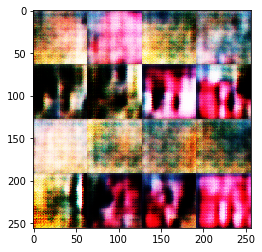

Model saved in path: ./tmp/model-64.ckpt
Epoch 89/500... Discriminator Loss: 0.5240... Generator Loss: 1.5904
Epoch 90/500... Discriminator Loss: 0.5164... Generator Loss: 1.3433
Epoch 92/500... Discriminator Loss: 0.4290... Generator Loss: 1.5594
Epoch 93/500... Discriminator Loss: 0.5462... Generator Loss: 1.4390
Epoch 94/500... Discriminator Loss: 0.3005... Generator Loss: 1.9393
Epoch 95/500... Discriminator Loss: 0.3160... Generator Loss: 2.1434
Epoch 97/500... Discriminator Loss: 0.3449... Generator Loss: 2.0547
Epoch 98/500... Discriminator Loss: 1.8055... Generator Loss: 0.4091
Epoch 99/500... Discriminator Loss: 0.5651... Generator Loss: 1.2490
Epoch 100/500... Discriminator Loss: 0.5133... Generator Loss: 1.4326
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


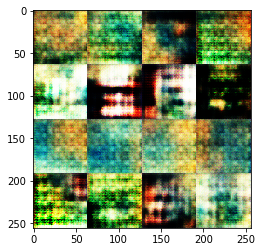

Model saved in path: ./tmp/model-64.ckpt
Epoch 102/500... Discriminator Loss: 0.5441... Generator Loss: 1.4298
Epoch 103/500... Discriminator Loss: 0.7142... Generator Loss: 1.0000
Epoch 104/500... Discriminator Loss: 0.7176... Generator Loss: 1.0870
Epoch 105/500... Discriminator Loss: 0.5954... Generator Loss: 1.1281
Epoch 107/500... Discriminator Loss: 0.4915... Generator Loss: 1.3847
Epoch 108/500... Discriminator Loss: 0.5466... Generator Loss: 1.3616
Epoch 109/500... Discriminator Loss: 0.7259... Generator Loss: 2.0350
Epoch 110/500... Discriminator Loss: 0.5934... Generator Loss: 1.4045
Epoch 112/500... Discriminator Loss: 0.6271... Generator Loss: 2.3670
Epoch 113/500... Discriminator Loss: 0.7928... Generator Loss: 1.7565
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


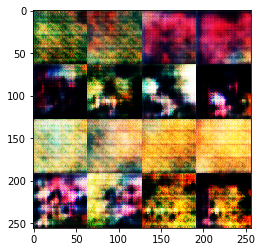

Model saved in path: ./tmp/model-64.ckpt
Epoch 114/500... Discriminator Loss: 0.5971... Generator Loss: 1.2649
Epoch 115/500... Discriminator Loss: 0.6888... Generator Loss: 1.2537
Epoch 117/500... Discriminator Loss: 1.0167... Generator Loss: 1.0476
Epoch 118/500... Discriminator Loss: 0.7074... Generator Loss: 1.1551
Epoch 119/500... Discriminator Loss: 0.7792... Generator Loss: 0.9761
Epoch 120/500... Discriminator Loss: 1.1307... Generator Loss: 0.6890
Epoch 122/500... Discriminator Loss: 0.5890... Generator Loss: 1.6189
Epoch 123/500... Discriminator Loss: 0.6287... Generator Loss: 1.3952
Epoch 124/500... Discriminator Loss: 0.5380... Generator Loss: 1.6890
Epoch 125/500... Discriminator Loss: 0.5699... Generator Loss: 1.9456
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


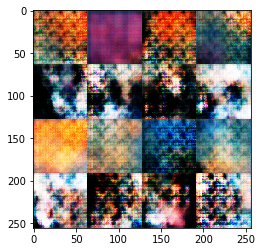

Model saved in path: ./tmp/model-64.ckpt
Epoch 127/500... Discriminator Loss: 0.6267... Generator Loss: 1.1201
Epoch 128/500... Discriminator Loss: 0.7937... Generator Loss: 0.9584
Epoch 129/500... Discriminator Loss: 0.5236... Generator Loss: 1.5454
Epoch 130/500... Discriminator Loss: 0.6398... Generator Loss: 1.2656
Epoch 132/500... Discriminator Loss: 0.9051... Generator Loss: 2.1121
Epoch 133/500... Discriminator Loss: 0.5815... Generator Loss: 1.3299
Epoch 134/500... Discriminator Loss: 0.8514... Generator Loss: 0.9377
Epoch 135/500... Discriminator Loss: 0.5682... Generator Loss: 2.2338
Epoch 137/500... Discriminator Loss: 0.5236... Generator Loss: 1.5259
Epoch 138/500... Discriminator Loss: 0.6243... Generator Loss: 1.4476
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


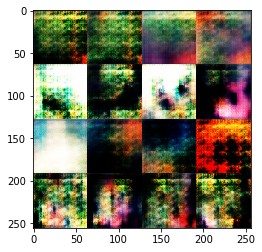

Model saved in path: ./tmp/model-64.ckpt
Epoch 139/500... Discriminator Loss: 0.6940... Generator Loss: 1.0009
Epoch 140/500... Discriminator Loss: 0.5706... Generator Loss: 1.2449
Epoch 142/500... Discriminator Loss: 0.4665... Generator Loss: 1.6085
Epoch 143/500... Discriminator Loss: 0.9728... Generator Loss: 0.7080
Epoch 144/500... Discriminator Loss: 0.6861... Generator Loss: 1.7850
Epoch 145/500... Discriminator Loss: 0.7401... Generator Loss: 2.4238
Epoch 147/500... Discriminator Loss: 0.6614... Generator Loss: 1.2394
Epoch 148/500... Discriminator Loss: 0.6267... Generator Loss: 1.3450
Epoch 149/500... Discriminator Loss: 0.5148... Generator Loss: 1.6286
Epoch 150/500... Discriminator Loss: 0.6932... Generator Loss: 1.0964
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


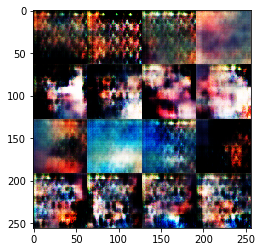

Model saved in path: ./tmp/model-64.ckpt
Epoch 152/500... Discriminator Loss: 0.7322... Generator Loss: 1.6767
Epoch 153/500... Discriminator Loss: 0.6546... Generator Loss: 1.2470
Epoch 154/500... Discriminator Loss: 0.6002... Generator Loss: 1.5275
Epoch 155/500... Discriminator Loss: 0.5401... Generator Loss: 1.4349
Epoch 157/500... Discriminator Loss: 0.8234... Generator Loss: 0.9134
Epoch 158/500... Discriminator Loss: 0.7389... Generator Loss: 0.9726
Epoch 159/500... Discriminator Loss: 0.6207... Generator Loss: 1.2318
Epoch 160/500... Discriminator Loss: 0.5402... Generator Loss: 1.4646
Epoch 162/500... Discriminator Loss: 0.7088... Generator Loss: 1.3190
Epoch 163/500... Discriminator Loss: 0.6249... Generator Loss: 1.5841
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


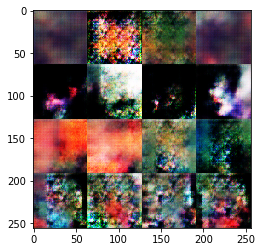

Model saved in path: ./tmp/model-64.ckpt
Epoch 164/500... Discriminator Loss: 0.5517... Generator Loss: 2.0496
Epoch 165/500... Discriminator Loss: 0.8447... Generator Loss: 1.9098
Epoch 167/500... Discriminator Loss: 0.6864... Generator Loss: 1.0451
Epoch 168/500... Discriminator Loss: 0.7711... Generator Loss: 0.8829
Epoch 169/500... Discriminator Loss: 0.6049... Generator Loss: 1.6324
Epoch 170/500... Discriminator Loss: 0.6223... Generator Loss: 1.3387
Epoch 172/500... Discriminator Loss: 0.5425... Generator Loss: 1.3431
Epoch 173/500... Discriminator Loss: 0.5934... Generator Loss: 1.1660
Epoch 174/500... Discriminator Loss: 0.5707... Generator Loss: 1.3245
Epoch 175/500... Discriminator Loss: 0.6825... Generator Loss: 1.9447
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


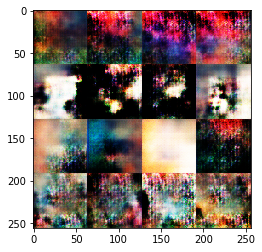

Model saved in path: ./tmp/model-64.ckpt
Epoch 177/500... Discriminator Loss: 0.6055... Generator Loss: 1.3935
Epoch 178/500... Discriminator Loss: 0.6170... Generator Loss: 1.2963
Epoch 179/500... Discriminator Loss: 0.7695... Generator Loss: 0.9660
Epoch 180/500... Discriminator Loss: 0.6387... Generator Loss: 1.2470
Epoch 182/500... Discriminator Loss: 0.5286... Generator Loss: 1.5478
Epoch 183/500... Discriminator Loss: 1.1206... Generator Loss: 2.1511
Epoch 184/500... Discriminator Loss: 0.8138... Generator Loss: 1.7886
Epoch 185/500... Discriminator Loss: 0.5978... Generator Loss: 1.2993
Epoch 187/500... Discriminator Loss: 0.5411... Generator Loss: 1.4070
Epoch 188/500... Discriminator Loss: 0.6256... Generator Loss: 1.5451
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


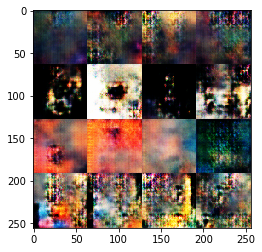

Model saved in path: ./tmp/model-64.ckpt
Epoch 189/500... Discriminator Loss: 0.5889... Generator Loss: 1.7193
Epoch 190/500... Discriminator Loss: 0.6204... Generator Loss: 1.3589
Epoch 192/500... Discriminator Loss: 0.5548... Generator Loss: 1.9011
Epoch 193/500... Discriminator Loss: 0.6328... Generator Loss: 1.2844
Epoch 194/500... Discriminator Loss: 0.6300... Generator Loss: 1.5093
Epoch 195/500... Discriminator Loss: 0.6878... Generator Loss: 1.9013
Epoch 197/500... Discriminator Loss: 0.7382... Generator Loss: 2.3421
Epoch 198/500... Discriminator Loss: 0.6113... Generator Loss: 1.3793
Epoch 199/500... Discriminator Loss: 0.6121... Generator Loss: 1.4562
Epoch 200/500... Discriminator Loss: 0.5787... Generator Loss: 1.2812
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


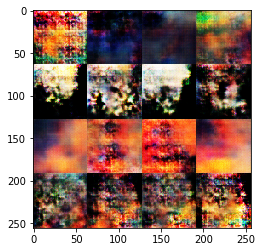

Model saved in path: ./tmp/model-64.ckpt
Epoch 202/500... Discriminator Loss: 0.5625... Generator Loss: 1.2046
Epoch 203/500... Discriminator Loss: 0.5056... Generator Loss: 1.5715
Epoch 204/500... Discriminator Loss: 0.5928... Generator Loss: 1.6390
Epoch 205/500... Discriminator Loss: 0.8338... Generator Loss: 0.7719
Epoch 207/500... Discriminator Loss: 0.5077... Generator Loss: 1.4736
Epoch 208/500... Discriminator Loss: 0.4023... Generator Loss: 2.2213
Epoch 209/500... Discriminator Loss: 2.1930... Generator Loss: 3.8786
Epoch 210/500... Discriminator Loss: 0.6807... Generator Loss: 1.2934
Epoch 212/500... Discriminator Loss: 0.5393... Generator Loss: 1.6179
Epoch 213/500... Discriminator Loss: 0.5658... Generator Loss: 1.5793
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


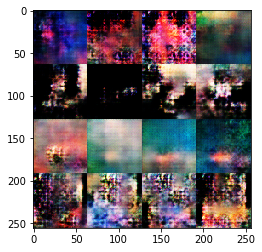

Model saved in path: ./tmp/model-64.ckpt
Epoch 214/500... Discriminator Loss: 0.7642... Generator Loss: 2.0702
Epoch 215/500... Discriminator Loss: 0.6582... Generator Loss: 1.0782
Epoch 217/500... Discriminator Loss: 0.5325... Generator Loss: 1.3351
Epoch 218/500... Discriminator Loss: 0.4513... Generator Loss: 1.8313
Epoch 219/500... Discriminator Loss: 0.8673... Generator Loss: 2.7729
Epoch 220/500... Discriminator Loss: 1.6909... Generator Loss: 2.6413
Epoch 222/500... Discriminator Loss: 0.6945... Generator Loss: 1.2299
Epoch 223/500... Discriminator Loss: 0.5924... Generator Loss: 1.3573
Epoch 224/500... Discriminator Loss: 0.5940... Generator Loss: 1.3728
Epoch 225/500... Discriminator Loss: 0.7449... Generator Loss: 0.8981
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


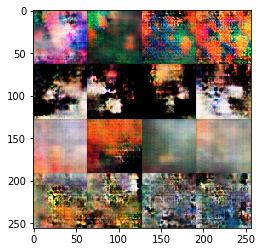

Model saved in path: ./tmp/model-64.ckpt
Epoch 227/500... Discriminator Loss: 0.4907... Generator Loss: 1.4016
Epoch 228/500... Discriminator Loss: 0.6043... Generator Loss: 1.7429
Epoch 229/500... Discriminator Loss: 1.2744... Generator Loss: 0.4724
Epoch 230/500... Discriminator Loss: 1.1078... Generator Loss: 2.1491
Epoch 232/500... Discriminator Loss: 0.6664... Generator Loss: 1.2665
Epoch 233/500... Discriminator Loss: 0.5839... Generator Loss: 1.3194
Epoch 234/500... Discriminator Loss: 0.5673... Generator Loss: 1.6523
Epoch 235/500... Discriminator Loss: 0.6545... Generator Loss: 2.2989
Epoch 237/500... Discriminator Loss: 0.6991... Generator Loss: 1.1084
Epoch 238/500... Discriminator Loss: 0.6112... Generator Loss: 1.2431
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


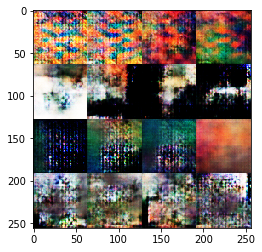

Model saved in path: ./tmp/model-64.ckpt
Epoch 239/500... Discriminator Loss: 2.6750... Generator Loss: 3.2062
Epoch 240/500... Discriminator Loss: 0.8360... Generator Loss: 0.8812
Epoch 242/500... Discriminator Loss: 0.6132... Generator Loss: 1.2069
Epoch 243/500... Discriminator Loss: 0.6055... Generator Loss: 1.3837
Epoch 244/500... Discriminator Loss: 0.6059... Generator Loss: 1.7767
Epoch 245/500... Discriminator Loss: 0.6334... Generator Loss: 1.5174
Epoch 247/500... Discriminator Loss: 0.5436... Generator Loss: 1.3515
Epoch 248/500... Discriminator Loss: 1.3168... Generator Loss: 2.5580
Epoch 249/500... Discriminator Loss: 0.9294... Generator Loss: 0.8991
Epoch 250/500... Discriminator Loss: 0.7638... Generator Loss: 0.9617
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


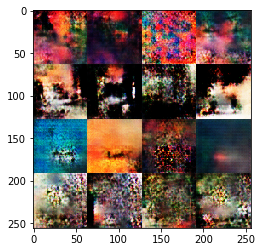

Model saved in path: ./tmp/model-64.ckpt
Epoch 252/500... Discriminator Loss: 0.5731... Generator Loss: 1.3660
Epoch 253/500... Discriminator Loss: 0.5687... Generator Loss: 1.4360
Epoch 254/500... Discriminator Loss: 0.6405... Generator Loss: 1.1694
Epoch 255/500... Discriminator Loss: 0.8809... Generator Loss: 0.8590
Epoch 257/500... Discriminator Loss: 0.6372... Generator Loss: 1.5248
Epoch 258/500... Discriminator Loss: 0.6273... Generator Loss: 1.4141
Epoch 259/500... Discriminator Loss: 0.6183... Generator Loss: 1.3711
Epoch 260/500... Discriminator Loss: 0.7941... Generator Loss: 1.3222
Epoch 262/500... Discriminator Loss: 0.5562... Generator Loss: 1.3934
Epoch 263/500... Discriminator Loss: 0.6174... Generator Loss: 1.4065
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


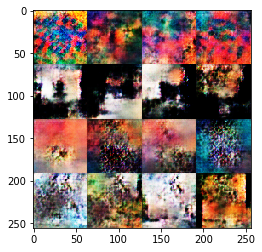

Model saved in path: ./tmp/model-64.ckpt
Epoch 264/500... Discriminator Loss: 0.5703... Generator Loss: 1.3440
Epoch 265/500... Discriminator Loss: 0.8482... Generator Loss: 0.8034
Epoch 267/500... Discriminator Loss: 0.9287... Generator Loss: 0.6655
Epoch 268/500... Discriminator Loss: 0.8393... Generator Loss: 0.9673
Epoch 269/500... Discriminator Loss: 0.6982... Generator Loss: 1.4061
Epoch 270/500... Discriminator Loss: 0.6334... Generator Loss: 1.2119
Epoch 272/500... Discriminator Loss: 0.4953... Generator Loss: 1.6113
Epoch 273/500... Discriminator Loss: 0.5568... Generator Loss: 1.4906
Epoch 274/500... Discriminator Loss: 0.7996... Generator Loss: 1.3801
Epoch 275/500... Discriminator Loss: 1.3332... Generator Loss: 0.3800
image shape in discriminator (?, 64, 64, 64)
image shape in discriminator (?, 64, 64, 64)


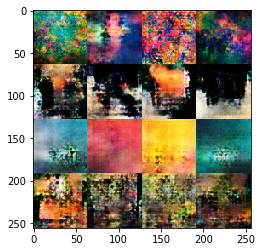

Model saved in path: ./tmp/model-64.ckpt
Epoch 277/500... Discriminator Loss: 0.6545... Generator Loss: 1.3680
Epoch 278/500... Discriminator Loss: 0.6893... Generator Loss: 1.4691
Epoch 279/500... Discriminator Loss: 0.5932... Generator Loss: 1.3454
Epoch 280/500... Discriminator Loss: 0.6968... Generator Loss: 1.2737
Epoch 282/500... Discriminator Loss: 0.6400... Generator Loss: 1.2266
Epoch 283/500... Discriminator Loss: 0.5443... Generator Loss: 1.4782
Epoch 284/500... Discriminator Loss: 0.9637... Generator Loss: 1.4763
Epoch 285/500... Discriminator Loss: 0.7455... Generator Loss: 1.0312
Epoch 287/500... Discriminator Loss: 0.5674... Generator Loss: 1.4157


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.3

epochs = 500

poster_dataset = helpers.Dataset('celeba', glob(os.path.join(data_dir, '*.jpg')))

with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, poster_dataset.get_batches,
          poster_dataset.shape, poster_dataset.image_mode)

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with Posters Dataset")
plt.legend()